In [3]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import csv
import seaborn as sns

In [4]:
df = pd.read_csv('amazon.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [6]:
# It is observed that the data type of all features are 'object', this may cause a few issuess such as
# incorrect mathematical computaions, parsing and conversion errors,
# misleading statistical analysis and visualizations and data validation issues.
#Therefore, we should replace the the data types with correct ones according to the database design.

# Before handling the data type issues, for simplicity and to save storage we can drop the over-explanatory features such as:
# img_link, product_link, review_content, about_product

# After dropping the chosen columns, modified dataset is to be prepared for data type conversion. This process includes:
# 1. stripping '%' and '₹' signs from the discount_percentage and price entries respectly
# to make it fit for mathematical calculations and statistical analysis
# 2. stripping  until the first' | ' sign from the category records to get rid of the subcategories, because the branching
# seems too complicated for straightforward analysis and have potential to be an issue in visualization
# 3. After determining the number of main categories, we can create a map from category to integers to form a Category_ID feature
# The purpose of this step is to maintain the data integrity and analytical flexibility by indexing the categories.



In [7]:
df.drop('review_content', axis=1, inplace=True)
df.drop('img_link', axis=1, inplace=True)
df.drop('product_link', axis=1, inplace=True)
df.drop('about_product', axis=1, inplace=True)

# Now, we have 12 features in our modified dataset

In [8]:
# Checking missing values
missing_percent = df.isnull().mean() * 100
df_missing_percentage = (df.isnull().sum() /len(df)) * 100
print(missing_percent)

product_id             0.000000
product_name           0.000000
category               0.000000
discounted_price       0.000000
actual_price           0.000000
discount_percentage    0.000000
rating                 0.000000
rating_count           0.136519
user_id                0.000000
user_name              0.000000
review_id              0.000000
review_title           0.000000
dtype: float64


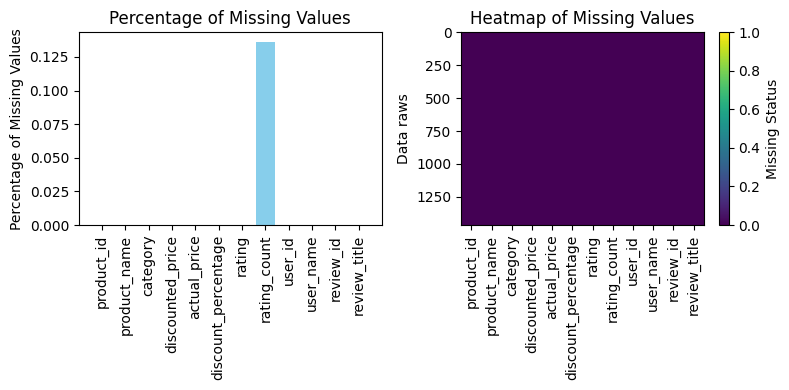

In [9]:
# Detecting Missing Values
plt.figure(figsize=(8, 4))

# 1. Bar plot for missing values count
plt.subplot(1, 2, 1)
missing = df.isnull().sum()
percentage_missing = (missing / df.shape[0]) * 100

plt.bar(percentage_missing.index, percentage_missing, color='skyblue')
plt.title("Percentage of Missing Values")
plt.ylabel("Percentage of Missing Values")
plt.xticks(rotation=90)

# 2. Heatmap for Missing Values
plt.subplot(1, 2, 2)
plt.imshow(df.isnull(), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Missing Status')
plt.title("Heatmap of Missing Values")
plt.ylabel("Data raws")
plt.xticks(ticks=range(len(df.columns)), labels=df.columns, rotation=90)


plt.tight_layout()
plt.show()

In [10]:
missing_values = df[df['rating_count'].isna()]
print(missing_values)

missing_count = df['rating_count'].isna().sum()
print(f"Number of missing values in 'rating_count': {missing_count}")

     product_id                                       product_name  \
282  B0B94JPY2N  Amazon Brand - Solimo 65W Fast Charging Braide...   
324  B0BQRJ3C47  REDTECH USB-C to Lightning Cable 3.3FT, [Apple...   

                                              category discounted_price  \
282  Computers&Accessories|Accessories&Peripherals|...             ₹199   
324  Computers&Accessories|Accessories&Peripherals|...             ₹249   

    actual_price discount_percentage rating rating_count  \
282         ₹999                 80%    3.0          NaN   
324         ₹999                 75%    5.0          NaN   

                          user_id    user_name      review_id  \
282  AE7CFHY23VAJT2FI4NZKKP6GS2UQ       Pranav   RUB7U91HVZ30   
324  AGJC5O5H5BBXWUV7WRIEIOOR3TVQ  Abdul Gafur  RQXD5SAMMPC6L   

                                     review_title  
282  The cable works but is not 65W as advertised  
324                               Awesome Product  
Number of missing values in 'r

In [11]:
# Since only two rows are missing in rating_count which is merely ~ 0.137% of tha data we can drop these rows
#df.dropna(subset=['rating_count'], inplace=True)

In [12]:
# Checking for duplicates
duplicates_count = df.duplicated().sum()
print(f"Number of duplicates: {duplicates_count}")

Number of duplicates: 76


In [13]:
# Printing the duplicated rows
duplicated_rows = df[df.duplicated()]
print(duplicated_rows)

      product_id                                       product_name  \
393   B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   
422   B08DDRGWTJ             MI Usb Type-C Cable Smartphone (Black)   
423   B082LZGK39  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
428   B08CF3D7QR  Portronics Konnect L POR-1081 Fast Charging 3A...   
456   B09KLVMZ3B  Portronics Konnect L 1.2M POR-1401 Fast Chargi...   
...          ...                                                ...   
1007  B0B9BXKBC7  WeCool S5 Long Selfie Stick, with Large Reinfo...   
1010  B07GVGTSLN  Wayona Usb Type C Fast Charger Cable Fast Char...   
1017  B0B9BD2YL4  KINGONE Wireless Charging Pencil (2nd Generati...   
1018  B0BMXMLSMM  Lapster 65W compatible for OnePlus Dash Warp C...   
1019  B0141EZMAI  Gizga Essentials USB WiFi Adapter for PC, 150 ...   

                                               category discounted_price  \
393   Computers&Accessories|Accessories&Peripherals|...             ₹15

In [14]:
df = df.drop_duplicates()

In [15]:
#Chhecking if the percentage and price columns have any decimal points so that we can determine the data type as float or integer
# If the output is True, then we replace the data type as float and for 'False' output we use integer
has_decimals_discounted = df['discounted_price'].str.contains(r'\.', regex=True).any()
has_decimals_actual = df['actual_price'].str.contains(r'\.', regex=True).any()
has_decimals_percentage = df['discount_percentage'].str.contains(r'\.', regex=True).any()

print(has_decimals_discounted, has_decimals_actual,has_decimals_percentage )  # True if any value contains a decimal point

True True False


In [16]:
df['discount_percentage'] = df['discount_percentage'].str.strip('%').astype('Float32')/100
df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype('Float32')
df['actual_price'] = df['actual_price'].str.replace('₹', '').str.replace(',', '').astype('Float32')

<ipython-input-16-e5fc9e5ac2c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discount_percentage'] = df['discount_percentage'].str.strip('%').astype('Float32')/100
<ipython-input-16-e5fc9e5ac2c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype('Float32')
<ipython-input-16-e5fc9e5ac2c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [17]:
# Extracting category names until '|' divider
df['category'] = df['category'].str.split('|').str[0]

# Getting distinct category names
distinct_categories = df['category'].unique()

# Printing distinct (main) category names
print("Distinct Categories:")
print(distinct_categories)

# Checking the number of distinct categories
print("Number of Distinct Categories:", len(distinct_categories))

Distinct Categories:
['Computers&Accessories' 'Electronics' 'MusicalInstruments'
 'OfficeProducts' 'Home&Kitchen' 'HomeImprovement' 'Toys&Games'
 'Car&Motorbike' 'Health&PersonalCare']
Number of Distinct Categories: 9


<ipython-input-17-9e06786f4ca1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['category'].str.split('|').str[0]


In [18]:
# DATABASE INDEXING

categories = ['Computers&Accessories', 'Electronics', 'MusicalInstruments',
              'OfficeProducts', 'Home&Kitchen', 'HomeImprovement',
              'Toys&Games', 'Car&Motorbike', 'Health&PersonalCare']

# Creating a dictionary mapping category names to category IDs
category_mapping = {category: idx+1 for idx, category in enumerate(categories)}

print(category_mapping)

# Add a 'CategoryID' column next to 'Category'
df.insert(df.columns.get_loc('category') + 1, 'CategoryID', df['category'].map(category_mapping))

{'Computers&Accessories': 1, 'Electronics': 2, 'MusicalInstruments': 3, 'OfficeProducts': 4, 'Home&Kitchen': 5, 'HomeImprovement': 6, 'Toys&Games': 7, 'Car&Motorbike': 8, 'Health&PersonalCare': 9}


In [19]:
# Checking if the modifications are implented on the dataset
df.head(2)

,product_id,product_name,category,CategoryID,discounted_price,actual_price,discount_percentage,rating,rating_count,user_id,user_name,review_id,review_title
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,1,399.0,1099.0,0.64,4.2,"24,269","AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo..."
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,1,199.0,349.0,0.43,4.0,"43,994","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go..."


In [20]:
# prompt: df teki rating_count kolonundaki , leri kaldır

# Remove commas from the 'rating_count' column
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '', regex=False)

# Now you can try converting it to numeric if needed
# df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

<ipython-input-20-de9927bf58f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '', regex=False)


In [21]:
# Convert to numeric and handle errors
df['discount_percentage'] = pd.to_numeric(df['discount_percentage'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')
df['rating_count'] = df['rating_count'].fillna(0).astype(int)


<ipython-input-21-a5707fb1e31c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discount_percentage'] = pd.to_numeric(df['discount_percentage'], errors='coerce')
<ipython-input-21-a5707fb1e31c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
<ipython-input-21-a5707fb1e31c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [22]:
df.head()

,product_id,product_name,category,CategoryID,discounted_price,actual_price,discount_percentage,rating,rating_count,user_id,user_name,review_id,review_title
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,1,399.0,1099.0,0.64,4.2,24269,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo..."
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,1,199.0,349.0,0.43,4.0,43994,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go..."
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,1,199.0,1899.0,0.9,3.9,7928,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W..."
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,1,329.0,699.0,0.53,4.2,94363,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product..."
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,1,154.0,399.0,0.61,4.2,16905,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second..."


In [23]:
# Change data types as specified
df = df.astype({
    'product_id': 'string',          # Convert to string
    'product_name': 'string',        # Convert to string
    'category': 'category',          # Convert to categorical
#'CategoryID': 'int64',           # Convert to integer
#'discounted_price': 'float64',   # Convert to float
#'actual_price': 'float64',       # Convert to float
    'rating': 'float64',             # Convert to float
#'rating_count': 'int64',         # Convert to integer
    'user_id': 'string',             # Convert to string
    'user_name': 'string',           # Convert to string
    'review_id': 'string',           # Convert to string
    'review_title': 'string'         # Convert to string
})

# Confirm the changes by displaying the data types
print(df.dtypes)

product_id             string[python]
product_name           string[python]
category                     category
CategoryID                      int64
discounted_price              Float32
actual_price                  Float32
discount_percentage           Float32
rating                        float64
rating_count                    int64
user_id                string[python]
user_name              string[python]
review_id              string[python]
review_title           string[python]
dtype: object


In [24]:
# Detecting outliers using IQR method
numeric_columns = df[['discounted_price', 'actual_price', 'rating', 'rating_count']]
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"Outliers in {col}: {outliers}")

Outliers in discounted_price: 214
Outliers in actual_price: 186
Outliers in rating: 73
Outliers in rating_count: 135


In [25]:
#Here it would not be right to neglect products with very few reviews because
# Ignoring smaller categories can lead to bias toward categories with larger review counts.
#Categories with fewer reviews might represent niche markets or new products, which could provide insights into emerging trends.
#Categories with low review counts may show extreme sentiments (either highly positive or negative) that can highlight specific customer concerns or praise.
#Analyzing these can uncover unique patterns or issues that need attention.

In [26]:
# Group by 'category' and count the number of reviews
result = df.groupby('category')['review_id'].count().reset_index()

# Rename columns for clarity
result.columns = ['category', 'review_count']

# Display result
print(result)



                category  review_count
0          Car&Motorbike             1
1  Computers&Accessories           392
2            Electronics           511
3    Health&PersonalCare             1
4           Home&Kitchen           448
5        HomeImprovement             2
6     MusicalInstruments             2
7         OfficeProducts            31
8             Toys&Games             1


<ipython-input-26-cd3e9cacc9d2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby('category')['review_id'].count().reset_index()


In [27]:
# Group by 'category' and count the number of products
result = df.groupby('category')['product_id'].count().reset_index()

# Rename columns for clarity
result.columns = ['category', 'product_count']

# Display result
print(result)


                category  product_count
0          Car&Motorbike              1
1  Computers&Accessories            392
2            Electronics            511
3    Health&PersonalCare              1
4           Home&Kitchen            448
5        HomeImprovement              2
6     MusicalInstruments              2
7         OfficeProducts             31
8             Toys&Games              1


<ipython-input-27-f1fe0c6ec780>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby('category')['product_id'].count().reset_index()


In [28]:
#Discounted Prices
#Reason: Discount percentages can vary widely across products or seasons, and what may appear as an outlier could be a special offer. Outliers in discount data might not be meaningful since discounts often fluctuate across categories, time periods, or promotions.

# CREATING DATABASE

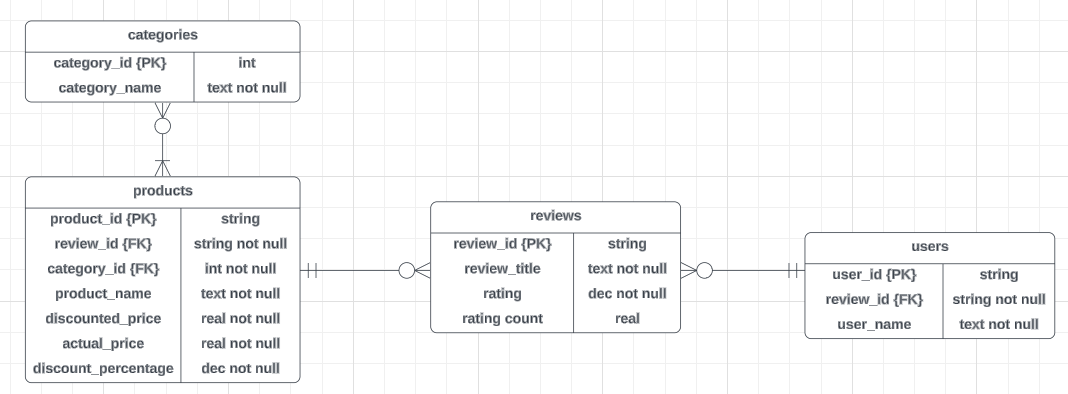

In [29]:
df.to_csv('new_amazon.csv', index=False)

In [30]:
# Load CSV file
csv_file = 'new_amazon.csv'
df = pd.read_csv(csv_file)

In [31]:
conn = sqlite3.connect('customer_sentiment.db')

In [32]:
cursor = conn.cursor()

### EXTRACTING CSV TABLES FROM THE DATASET

In [33]:
# Create Categories csv table
categories = df[['category', 'CategoryID']].drop_duplicates().reset_index(drop=True)
categories.to_csv('categories.csv', index=False)

In [34]:
# Create Users csv table
users = df[['user_id', 'review_id','user_name']].drop_duplicates().reset_index(drop=True)
users.to_csv('users.csv', index=False)

In [35]:
# Create Reviews csv table
reviews = df[['review_id', 'review_title', 'rating', 'rating_count']]
reviews = reviews[['review_id', 'review_title', 'rating', 'rating_count']]
reviews.to_csv('reviews.csv', index=False)

In [36]:
# Create Products csv table
products = df[['product_id', 'review_id', 'product_name', 'CategoryID','discounted_price', 'actual_price', 'discount_percentage']]
products = products[['product_id', 'product_name', 'CategoryID','discounted_price', 'actual_price', 'discount_percentage', 'review_id',]]
products.to_csv('products.csv', index=False)

## CREATING TABLES

In [37]:
#CATEGORIES TABLE
cursor.execute('''
CREATE TABLE IF NOT EXISTS Categories (
    CategoryID INTEGER PRIMARY KEY,
    category TEXT NOT NULL
)
 ''')

In [38]:
#USERS TABLE
cursor.execute('''
CREATE TABLE IF NOT EXISTS Users (
    user_id VARCHAR(250) PRIMARY KEY,
    review_id VARCHAR(250) NOT NULL,
    user_name TEXT NOT NULL,
    FOREIGN KEY (review_id) REFERENCES Reviews (review_id)
)
''')

In [39]:
#PRODUCTS TABLE
cursor.execute('''
CREATE TABLE IF NOT EXISTS Products (
    product_id VARCHAR(100) PRIMARY KEY,
    product_name TEXT NOT NULL,
    CategoryID INTEGER NOT NULL,
    discounted_price DEC NOT NULL,
    actual_price DEC NOT NULL,
    discount_percentage DEC NOT NULL,
    review_id VARCHAR(250) NOT NULL,
    FOREIGN KEY (CategoryID) REFERENCES Categories (CategoryID)
    FOREIGN KEY (review_id) REFERENCES Reviews (review_id)
)
 ''')

In [40]:
#REVIEWS TABLE
cursor.execute('''
CREATE TABLE IF NOT EXISTS Reviews (
    review_id VARCHAR(100) PRIMARY KEY,
    review_title TEXT NOT NULL,
    rating DEC NOT NULL,
    rating_count INT NOT NULL

)
''')

### POPULATING THE TABLES

In [41]:
data_path = 'categories.csv'  # CSV file path

with open(data_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    cursor.executemany('''
    INSERT OR IGNORE INTO Categories (category, CategoryID)
    VALUES (:category, :CategoryID)
    ''', reader)
    # Commit changes and close the connection
conn.commit()

In [42]:
data_path = 'users.csv'  # CSV file path

with open(data_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    cursor.executemany('''
    INSERT OR IGNORE INTO users (user_id, review_id, user_name )
    VALUES (:user_id, :review_id, :user_name)
    ''', reader)
    # Commit changes and close the connection
conn.commit()

In [43]:
data_path = 'products.csv'  # CSV file path

with open(data_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    cursor.executemany('''
    INSERT OR IGNORE INTO products ( product_id, product_name, CategoryID, discounted_price, actual_price, discount_percentage, review_id)
    VALUES (:product_id, :product_name, :CategoryID, :discounted_price, :actual_price, :discount_percentage, :review_id)
    ''', reader)
    # Commit changes and close the connection
conn.commit()

In [44]:
data_path = 'reviews.csv'  # CSV file path

with open(data_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    cursor.executemany('''
    INSERT OR IGNORE INTO Reviews (review_id, review_title, rating, rating_count)
    VALUES (:review_id, :review_title, :rating, :rating_count)
    ''', reader)
    # Commit changes and close the connection
conn.commit()

# EDA

Correlation between Rating and Discount Percentage: -0.15789628129268


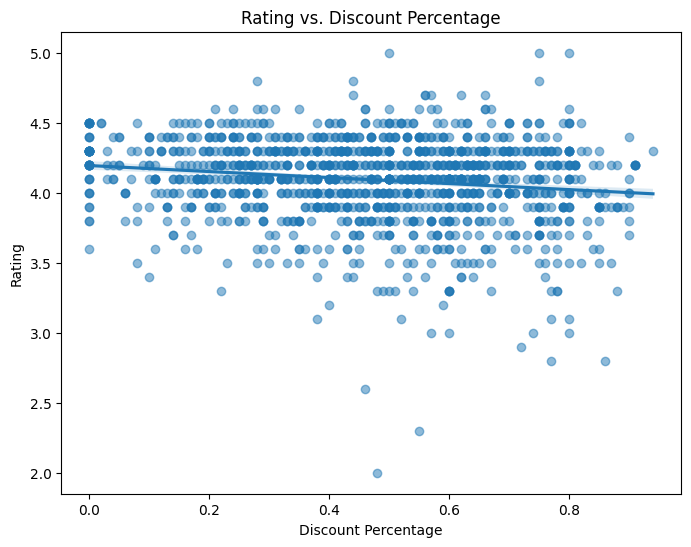

Correlation between Rating Count and Rating: 0.10455910586204495


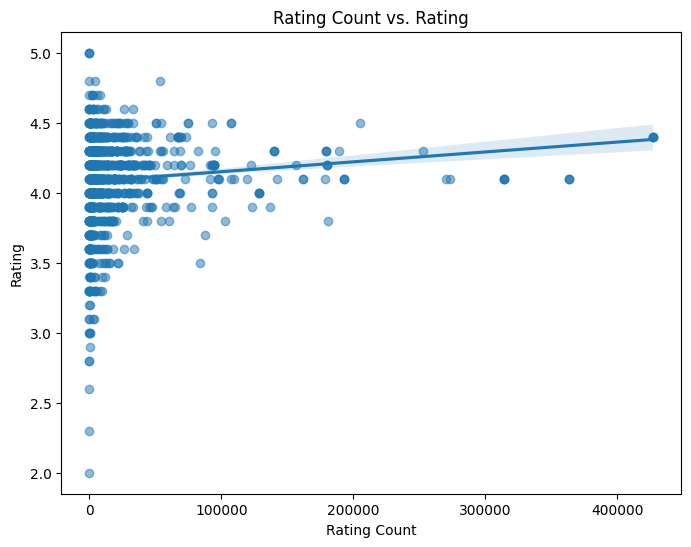

Correlation between Actual Price and Rating: 0.12675130145321253


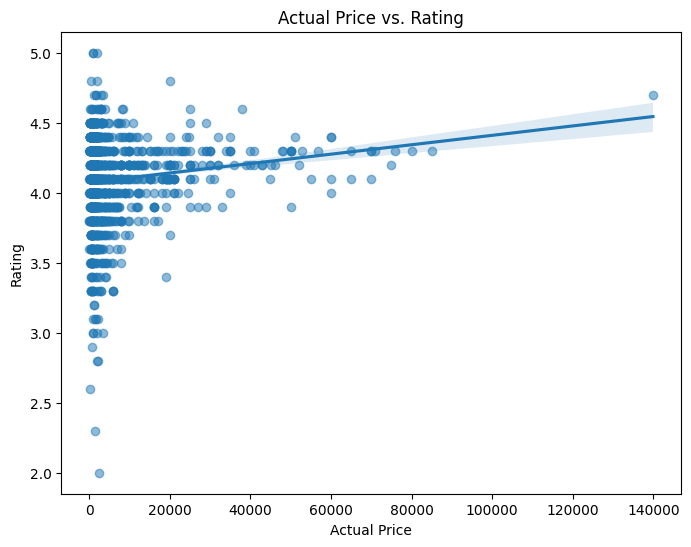

Correlation between Actual Price and Discount Percentage: -0.11301445043009388


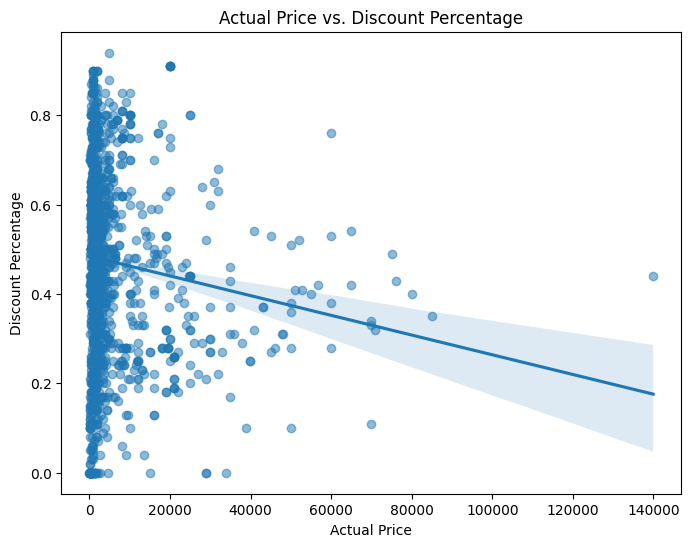

Correlation between Rating Count and Discount Percentage: 0.016391138800391256


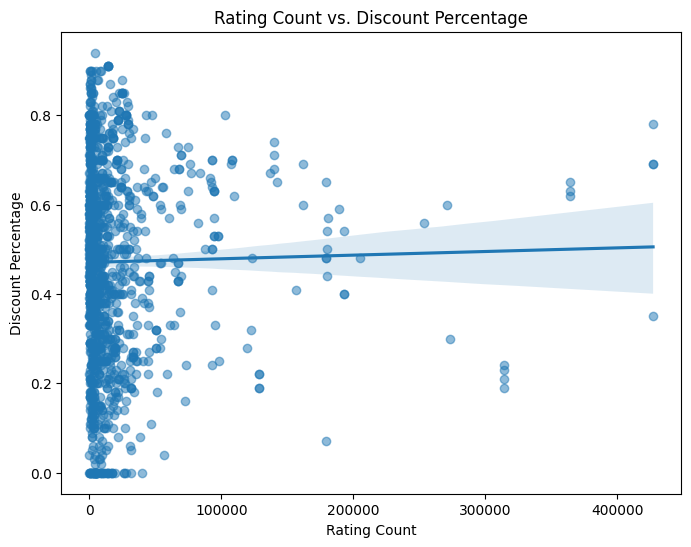

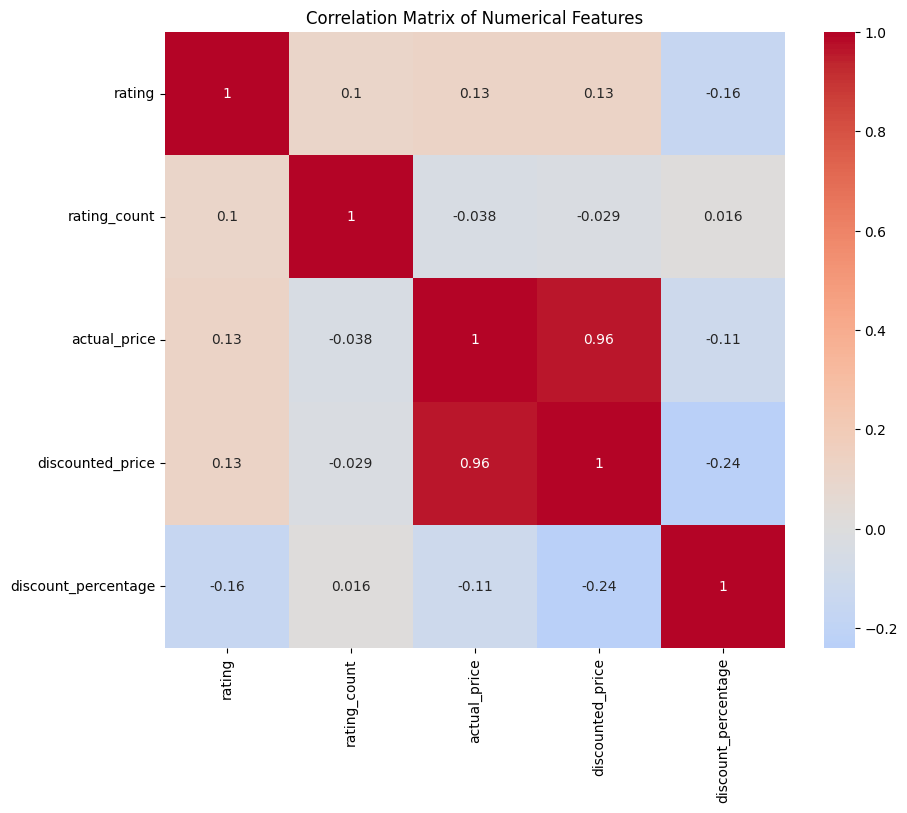

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df' and contains the processed data from your notebook

# --- 1. Rating and Discount Relationship ---
correlation_rating_discount = df['rating'].corr(df['discount_percentage'])
print(f"Correlation between Rating and Discount Percentage: {correlation_rating_discount}")

# Visualization (Scatter Plot with Trend Line)
plt.figure(figsize=(8, 6))
sns.regplot(x='discount_percentage', y='rating', data=df, scatter_kws={'alpha':0.5})
plt.title('Rating vs. Discount Percentage')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')
plt.show()

# --- 2. Rating Count and Rating ---
correlation_rating_count_rating = df['rating_count'].corr(df['rating'])
print(f"Correlation between Rating Count and Rating: {correlation_rating_count_rating}")

# Visualization (Scatter Plot with Trend Line)
plt.figure(figsize=(8, 6))
sns.regplot(x='rating_count', y='rating', data=df, scatter_kws={'alpha':0.5})
plt.title('Rating Count vs. Rating')
plt.xlabel('Rating Count')
plt.ylabel('Rating')
plt.show()

# --- 3. Price and Rating ---
correlation_price_rating = df['actual_price'].corr(df['rating'])
print(f"Correlation between Actual Price and Rating: {correlation_price_rating}")

# Visualization (Scatter Plot with Trend Line)
plt.figure(figsize=(8, 6))
sns.regplot(x='actual_price', y='rating', data=df, scatter_kws={'alpha':0.5})
plt.title('Actual Price vs. Rating')
plt.xlabel('Actual Price')
plt.ylabel('Rating')
plt.show()

# --- 4. Price and Discount ---
correlation_price_discount = df['actual_price'].corr(df['discount_percentage'])
print(f"Correlation between Actual Price and Discount Percentage: {correlation_price_discount}")

# Visualization (Scatter Plot with Trend Line)
plt.figure(figsize=(8, 6))
sns.regplot(x='actual_price', y='discount_percentage', data=df, scatter_kws={'alpha':0.5})
plt.title('Actual Price vs. Discount Percentage')
plt.xlabel('Actual Price')
plt.ylabel('Discount Percentage')
plt.show()
# --- 5. Rating Count and discount ---
correlation_ratingcount_discount = df['rating_count'].corr(df['discount_percentage'])
print(f"Correlation between Rating Count and Discount Percentage: {correlation_ratingcount_discount}")

# Visualization (Scatter Plot with Trend Line)
plt.figure(figsize=(8, 6))
sns.regplot(x='rating_count', y='discount_percentage', data=df, scatter_kws={'alpha':0.5})
plt.title('Rating Count vs. Discount Percentage')
plt.xlabel('Rating Count')
plt.ylabel('Discount Percentage')
plt.show()

# --- Correlation Matrix (Heatmap) ---
correlation_matrix = df[['rating', 'rating_count', 'actual_price', 'discounted_price', 'discount_percentage']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

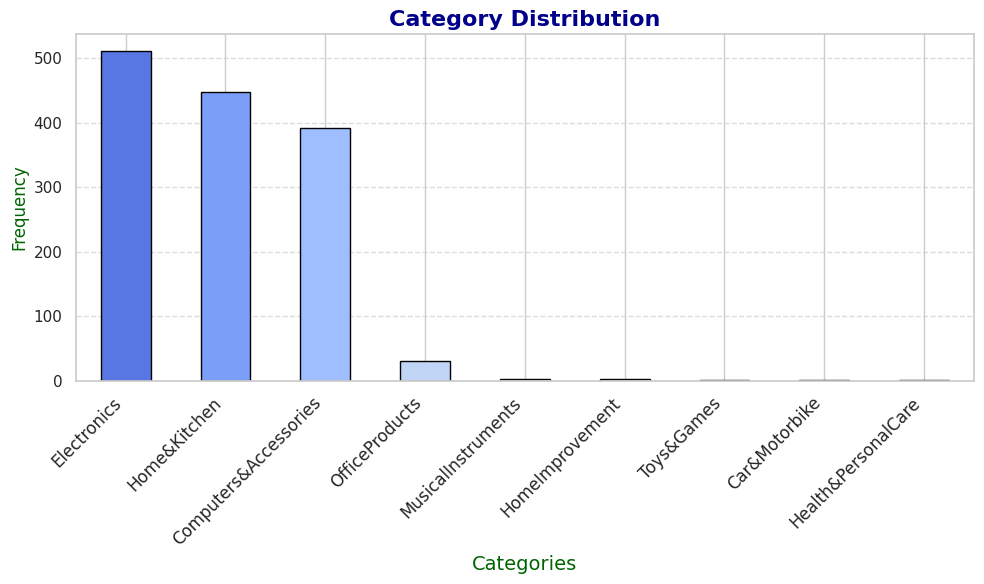

In [ ]:
# Setting aesthetic style using seaborn
sns.set(style="whitegrid")

# Example: Plot a bar plot for a categorical column, say 'category_column'
plt.figure(figsize=(10, 6))
ax = df['category'].value_counts().plot(kind='bar', color=sns.color_palette("coolwarm", len(df['category'].unique())), edgecolor='black')

# Customize the plot for better aesthetics
ax.set_title('Category Distribution', fontsize=16, weight='bold', color='darkblue')
ax.set_xlabel('Categories', fontsize=14, color='darkgreen')
ax.set_ylabel('Frequency', fontsize=14, color='darkgreen')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12, color='darkgreen')

# Add gridlines and style
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#TESTING

#TESTING
cursor.execute("""
SELECT
    c.category,
    SUM(r.rating_count) AS total_rating_count
FROM
    categories c
JOIN
    products p ON c.CategoryID = p.CategoryID
JOIN
    reviews r ON p.review_id = r.review_id
GROUP BY
    c.category
ORDER BY
    total_rating_count DESC;

""")
data_ratings = cursor.fetchall()

df_ratings = pd.DataFrame(data_ratings, columns = ['Category', 'Total_Ratings'])

print(df_ratings)


                Category  Total_Ratings
0            Electronics       14208397
1  Computers&Accessories        6335176
2           Home&Kitchen        2991069
3         OfficeProducts         149675
4     MusicalInstruments          88882
5             Toys&Games          15867
6        HomeImprovement           8566
7    Health&PersonalCare           3663
8          Car&Motorbike           1118


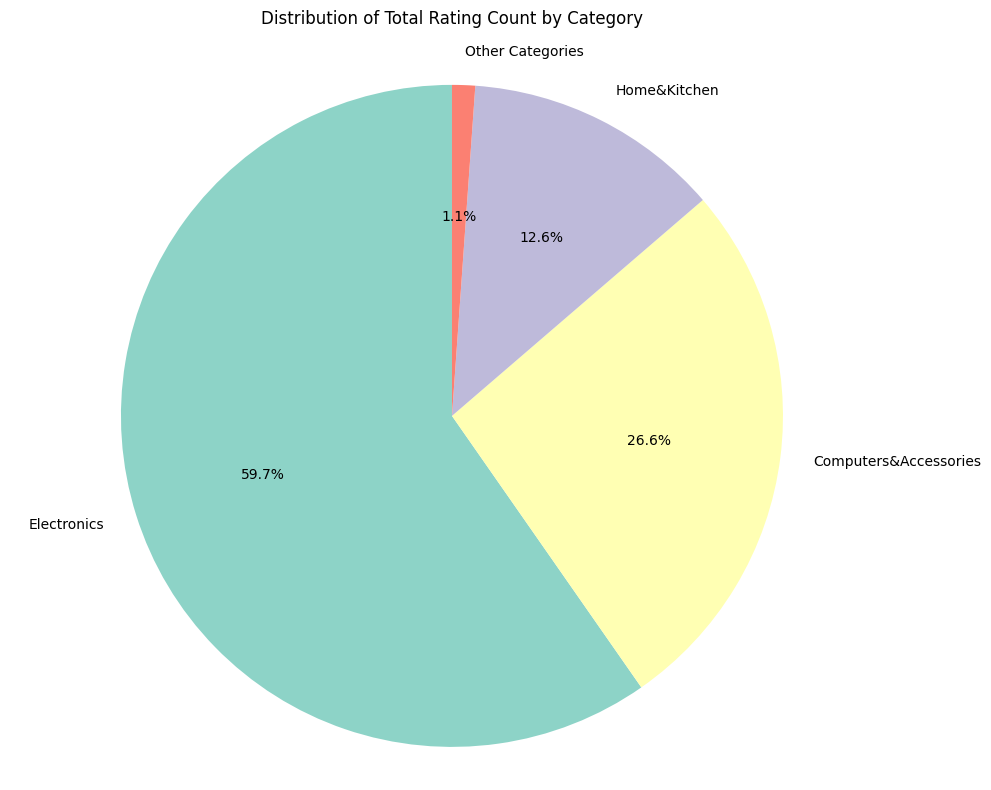

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_ratings and df_reviews are already defined and merged into df_combined

# 1. Calculate percentage for each category
df_ratings['Percentage'] = (df_ratings['Total_Ratings'] / df_ratings['Total_Ratings'].sum()) * 100

# 2. Filter categories below 12%
categories_below_12 = df_ratings[df_ratings['Percentage'] < 12]['Category'].tolist()

# 3. Group into 'Others'
others_df = pd.DataFrame({'Category': ['Other Categories'],
                          'Total_Ratings': [df_ratings[df_ratings['Category'].isin(categories_below_12)]['Total_Ratings'].sum()]})

# 4. Update the original DataFrame
df_ratings_updated = df_ratings[~df_ratings['Category'].isin(categories_below_12)]  # Keep categories above 12%
df_ratings_updated = pd.concat([df_ratings_updated, others_df], ignore_index=True)  # Add 'Others'

# 5. Create the pie chart
plt.figure(figsize=(10, 8))  # Increase figure size for better label visibility
plt.pie(df_ratings_updated['Total_Ratings'],
        labels=df_ratings_updated['Category'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("Set3", len(df_ratings_updated)))
plt.title('Distribution of Total Rating Count by Category',pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
cursor.execute("""
SELECT
    c.category,
    COUNT(r.review_id) AS total_reviews
FROM
    categories c
JOIN
    products p ON c.CategoryID = p.CategoryID
JOIN
    reviews r ON p.review_id = r.review_id
GROUP BY
    c.category
ORDER BY
    total_reviews DESC;

""")

data_reviews = cursor.fetchall()

# Convert the result into a DataFrame
df_reviews = pd.DataFrame(data_reviews, columns=['Category', 'Total_Reviews'])

# Display the DataFrame
print(df_reviews)


                Category  Total_Reviews
0            Electronics            490
1           Home&Kitchen            448
2  Computers&Accessories            375
3         OfficeProducts             31
4     MusicalInstruments              2
5        HomeImprovement              2
6             Toys&Games              1
7    Health&PersonalCare              1
8          Car&Motorbike              1


<ipython-input-305-f0d5e8c2491d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Total_Reviews', data=df_reviews, palette='viridis', ax=axes[0])


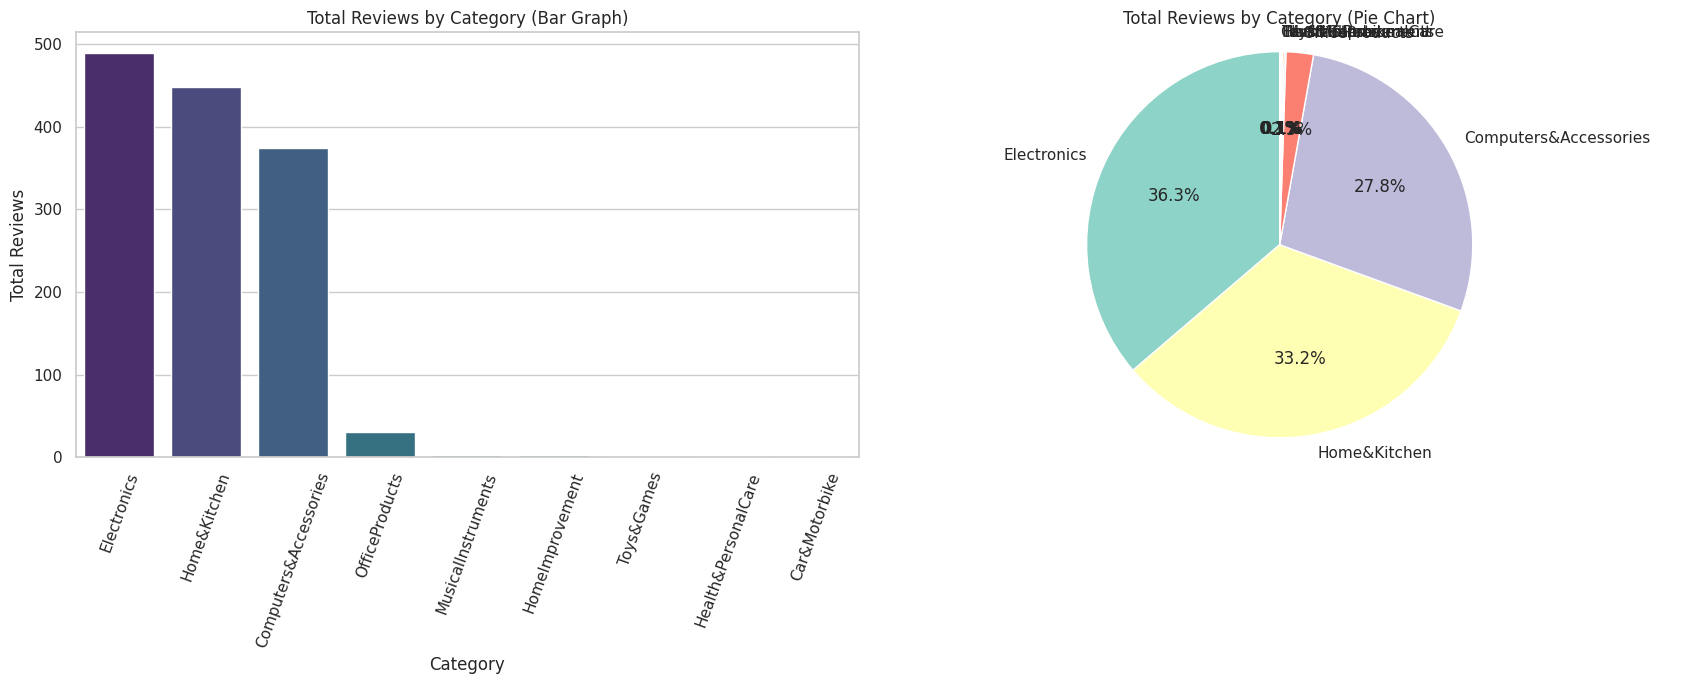

In [ ]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # 1 row, 2 columns

# Bar Graph in the first subplot
sns.barplot(x='Category', y='Total_Reviews', data=df_reviews, palette='viridis', ax=axes[0])
axes[0].set_title('Total Reviews by Category (Bar Graph)')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Total Reviews')
axes[0].tick_params(axis='x', rotation=70)

# Pie Chart in the second subplot
axes[1].pie(df_reviews['Total_Reviews'], labels=df_reviews['Category'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(df_reviews)))
axes[1].set_title('Total Reviews by Category (Pie Chart)')
axes[1].axis('equal')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

<ipython-input-306-720e69af487d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='actual_price', palette='pastel')
<ipython-input-306-720e69af487d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='discounted_price', palette='pastel')


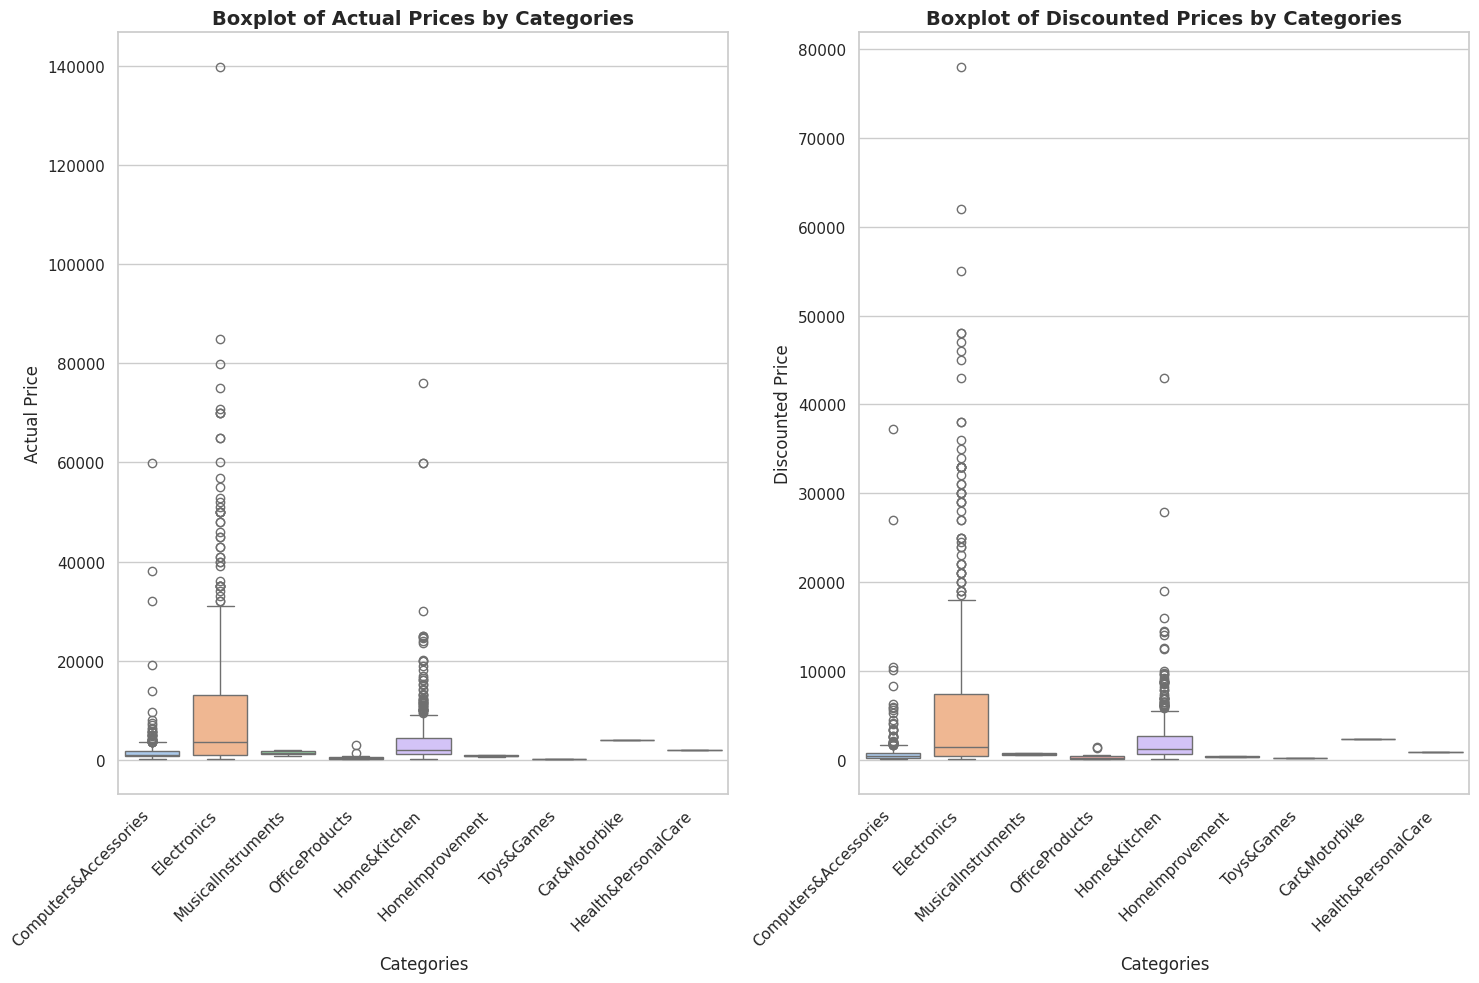

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size and style
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# ---- BOX PLOT ----
plt.subplot(1, 2, 1)  # Create a subplot (2 rows, 2 columns, position 2)
sns.boxplot(data=df, x='category', y='actual_price', palette='pastel')
plt.title('Boxplot of Actual Prices by Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Actual Price', fontsize=12)

# ---- BOX PLOT FOR DISCOUNTED PRICE ----
plt.subplot(1, 2, 2)  # Create a subplot (2 rows, 2 columns, position 4)
sns.boxplot(data=df, x='category', y='discounted_price', palette='pastel')
plt.title('Boxplot of Discounted Prices by Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Discounted Price', fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
# Assuming your DataFrame is named df and it contains 'rating' and 'category' columns

# Compute the average rating per category
average_ratings_by_category = df.groupby('category')['rating'].mean()

# Display the result
print(average_ratings_by_category)


category
Good       3.989562
Issue      3.133333
Neutral    3.625000
Name: rating, dtype: float64


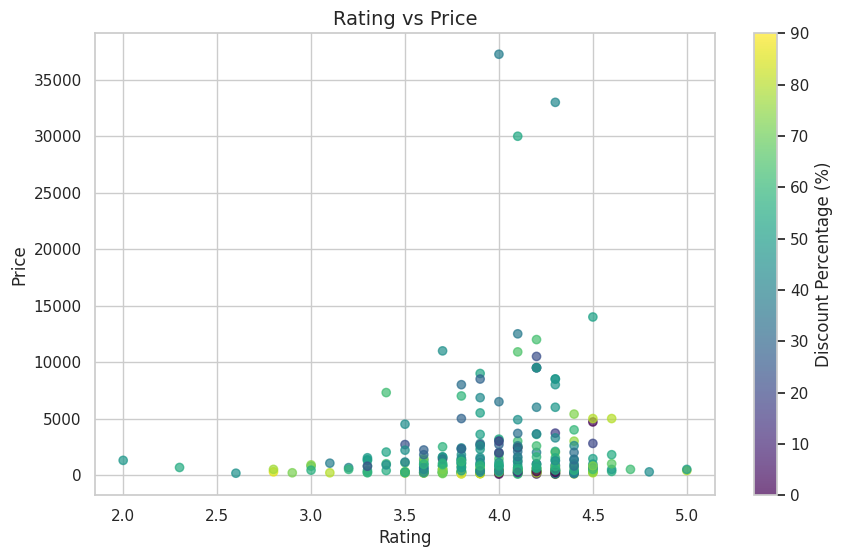

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['rating'], df['discounted_price'], c=df['discount_percentage'], cmap='viridis', alpha=0.7)
plt.title('Rating vs Price', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.colorbar(scatter, label='Discount Percentage (%)')
plt.show()

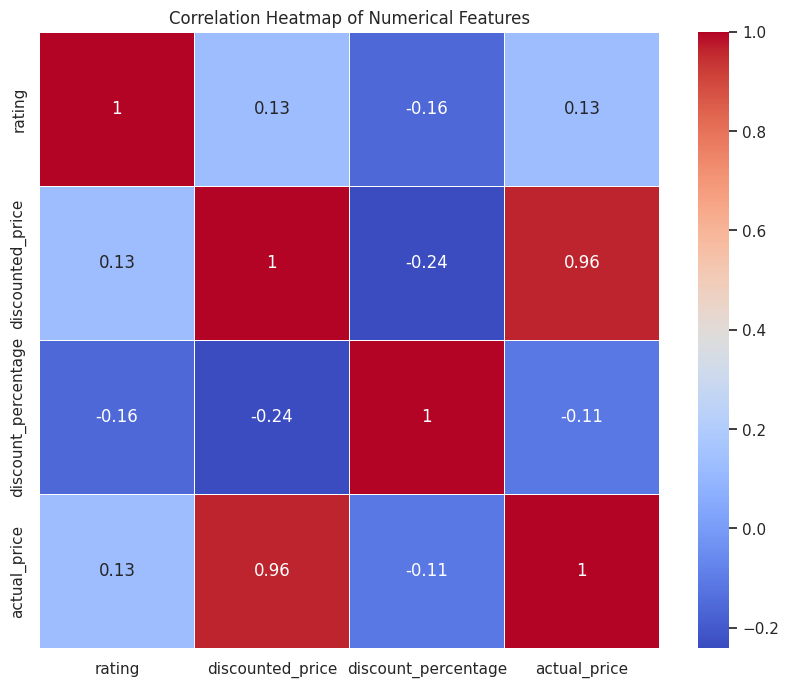

In [ ]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = df[['rating', 'discounted_price', 'discount_percentage', 'actual_price']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
# Calculating quantiles (e.g., 0.25, 0.5, 0.75 for quartiles)
quantiles = np.quantile(df['discounted_price'], [0.25, 0.5, 0.75])

print("Quantiles of Discounted Prices (in millions):")
print(f"25th percentile (Q1): {quantiles[0]}" )
print(f"50th percentile (Q2/Median): {quantiles[1]}")
print(f"75th percentile (Q3): {quantiles[2]}")

mean_price = df['discounted_price'].mean()
print(f"Mean Price: {mean_price:.2f}")

Quantiles of Discounted Prices (in millions):
25th percentile (Q1): 299.0
50th percentile (Q2/Median): 649.0
75th percentile (Q3): 1601.0
Mean Price: 1863.23


## NLP

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Preprocess text
def preprocess_text(text):
    if pd.isnull(text):
        return ""  # Handle missing values
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])  # Remove stopwords & stem
    return text

# Apply preprocessing
df['cleaned_reviews'] = df['review_title'].apply(preprocess_text)

print(df[['review_title', 'cleaned_reviews']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        review_title  \
0  Satisfied,Charging is really fast,Value for mo...   
1  A Good Braided Cable for Your Type C Device,Go...   
2  Good speed for earlier versions,Good Product,W...   
3  Good product,Good one,Nice,Really nice product...   
4  As good as original,Decent,Good one for second...   

                                     cleaned_reviews  
0  satisfiedcharg realli fastvalu moneyproduct re...  
1  good braid cabl type c devicegood qualiti prod...  
2  good speed earlier versionsgood productwork go...  
3  good productgood onenicer nice productveri fir...  
4  good originaldecentgood one secondari usebest ...  


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Get sentiment scores
df['sentiment_score'] = df['cleaned_reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Classify sentiment based on score
def categorize_sentiment(score):
    if score >= 0.05:   # Positive sentiment
        return 'Good'
    elif score <= -0.05:  # Negative sentiment
        return 'Bad'
    else:  # Neutral sentiment
        return 'Neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Display results
print(df[['review_title', 'cleaned_reviews', 'sentiment_score', 'sentiment_category']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                        review_title  \
0  Satisfied,Charging is really fast,Value for mo...   
1  A Good Braided Cable for Your Type C Device,Go...   
2  Good speed for earlier versions,Good Product,W...   
3  Good product,Good one,Nice,Really nice product...   
4  As good as original,Decent,Good one for second...   

                                     cleaned_reviews  sentiment_score  \
0  satisfiedcharg realli fastvalu moneyproduct re...           0.4404   
1  good braid cabl type c devicegood qualiti prod...           0.4404   
2  good speed earlier versionsgood productwork go...           0.6908   
3  good productgood onenicer nice productveri fir...           0.8750   
4  good originaldecentgood one secondari usebest ...           0.4404   

  sentiment_category  
0               Good  
1               Good  
2               Good  
3               Good  
4               Good  


<ipython-input-323-6d9975529b11>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=df, palette='viridis')


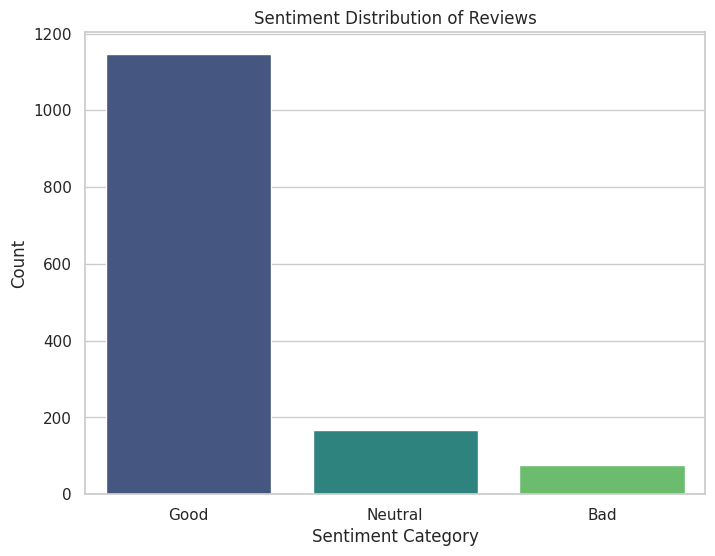

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_category', data=df, palette='viridis')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


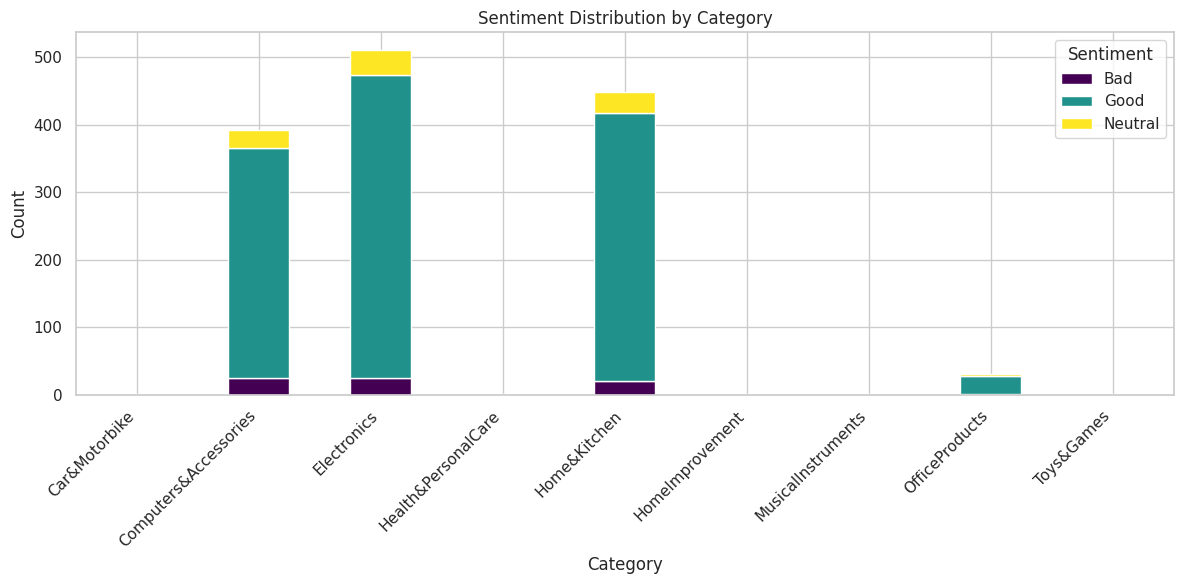

sentiment_category,Bad,Good,Neutral
category,,,
Car&Motorbike,0,1,0
Computers&Accessories,25,341,26
Electronics,25,449,37
Health&PersonalCare,0,1,0
Home&Kitchen,20,397,31
HomeImprovement,0,2,0
MusicalInstruments,0,2,0
OfficeProducts,1,27,3
Toys&Games,0,1,0


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Preprocessing
nltk.download('stopwords')
nltk.download('vader_lexicon')

stop_words = set(stopwords.words('english'))

# Text cleaning function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing
df['cleaned_reviews'] = df['review_title'].apply(preprocess_text)

# Sentiment Analysis using VADER
analyzer = SentimentIntensityAnalyzer()

# Get sentiment scores
df['sentiment_score'] = df['cleaned_reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Categorize sentiment
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Good'
    elif score <= -0.05:
        return 'Bad'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Group data by category and sentiment
category_sentiment = df.groupby(['category', 'sentiment_category']).size().unstack(fill_value=0)

# Visualize grouped data
category_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Display processed sentiment table
category_sentiment


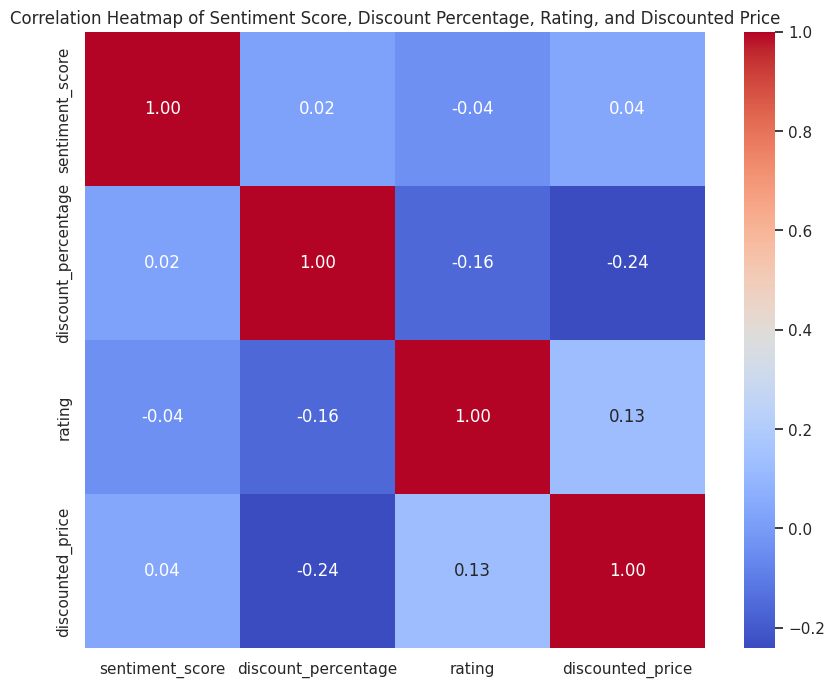

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Ensure that 'discount_percentage', 'rating', and 'discounted_price' are numeric types

# Convert columns to numeric if they aren't already
df['discount_percentage'] = pd.to_numeric(df['discount_percentage'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['discounted_price'] = pd.to_numeric(df['discounted_price'], errors='coerce')

# Since there is no 'sentiment_score' in the dataframe, i'm generating a new column with random value to proceed.
# If you already have a column for sentiment scores, replace this with your actual sentiment score column
import numpy as np
df['sentiment_score'] = np.random.rand(len(df))

# Select the columns for correlation analysis
correlation_data = df[['sentiment_score', 'discount_percentage', 'rating', 'discounted_price']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Sentiment Score, Discount Percentage, Rating, and Discounted Price')
plt.show()